**Task 1**

In [38]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np
from torchsummary import summary
from torchviz import make_dot
from google.colab import drive
import matplotlib.pyplot as plt

In [27]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data_path = '/content/drive/MyDrive/dataset/apex'

Feature Extraction

In [29]:
def get_x(path, width):
    "Gets the x value from the image filename"
    return (float(int(path.split("_")[0])) - width / 2) / (width / 2)


def get_y(path, height):
    "Gets the y value from the image filename"
    return (float(int(path.split("_")[1])) - height / 2) / (height / 2)

Data Augmentation

In [30]:
class XYDataset(torch.utils.data.Dataset):

    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = PIL.Image.open(image_path)
        width, height = image.size
        x = float(get_x(os.path.basename(image_path), width))
        y = float(get_y(os.path.basename(image_path), height))

        if float(np.random.rand(1)) > 0.5:
            image = transforms.functional.hflip(image)
            x = -x

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return image, torch.tensor([x, y]).float()

Train-Test Split

In [31]:
dataset = XYDataset(data_path, random_hflips=False)


test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])

In [32]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

Load Base Model

In [33]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

In [34]:
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

NUM_EPOCHS = 50
BEST_MODEL_PATH = '/best_steering_model_xy.pth'
best_loss = 1e9

Model Summary

In [35]:
class ModifiedResNet18(torch.nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.fc = torch.nn.Linear(512, 2)

    def forward(self, x):
        return self.fc(x)

modified_model = ModifiedResNet18()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modified_model = modified_model.to(device)
dummy_input = torch.randn(1, 512).to(device)
output = modified_model(dummy_input)
graph = make_dot(output, params=dict(modified_model.named_parameters()))
graph_path = "/mnt/data/modified_resnet18_fc_graph.jpg"
graph.render(graph_path[:-4], format="jpg")

'/mnt/data/modified_resnet18_fc_graph.jpg'

In [37]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)

train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        train_loss += float(loss)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval().to(device)
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss

<ipython-input-30-926b25b0c33b>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(np.random.rand(1)) > 0.5:


Epoch: 1, Train Loss: 0.055508, Test Loss: 0.038045
Epoch: 2, Train Loss: 0.045131, Test Loss: 0.052121
Epoch: 3, Train Loss: 0.037453, Test Loss: 0.021024
Epoch: 4, Train Loss: 0.032333, Test Loss: 0.026198
Epoch: 5, Train Loss: 0.037509, Test Loss: 0.021884
Epoch: 6, Train Loss: 0.029600, Test Loss: 0.033824
Epoch: 7, Train Loss: 0.025152, Test Loss: 0.018623
Epoch: 8, Train Loss: 0.028492, Test Loss: 0.033237
Epoch: 9, Train Loss: 0.026582, Test Loss: 0.024078
Epoch: 10, Train Loss: 0.024432, Test Loss: 0.022291
Epoch: 11, Train Loss: 0.022241, Test Loss: 0.024562
Epoch: 12, Train Loss: 0.021378, Test Loss: 0.020160
Epoch: 13, Train Loss: 0.021462, Test Loss: 0.020821
Epoch: 14, Train Loss: 0.023700, Test Loss: 0.034325
Epoch: 15, Train Loss: 0.016651, Test Loss: 0.022159
Epoch: 16, Train Loss: 0.021348, Test Loss: 0.027624
Epoch: 17, Train Loss: 0.015595, Test Loss: 0.027873
Epoch: 18, Train Loss: 0.016861, Test Loss: 0.024292
Epoch: 19, Train Loss: 0.016549, Test Loss: 0.016231
Ep

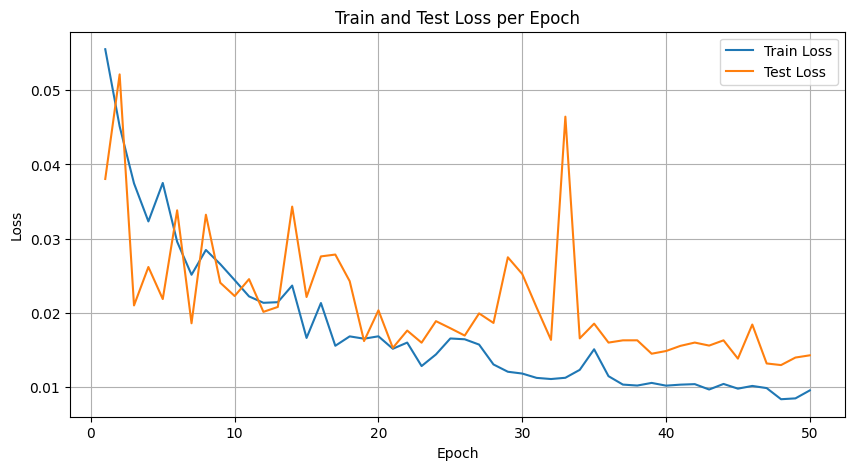

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()